In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers, callbacks
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, roc_auc_score

print("TensorFlow Version:", tf.__version__)
print("PyTorch Version:", torch.__version__)
print("-" * 30)

TensorFlow Version: 2.18.0
PyTorch Version: 2.6.0+cu124
------------------------------


In [10]:
# =============================================================================
# # 1. Pengumpulan & Pembersihan Data
# =============================================================================
print("Memulai Tahap 1: Pengumpulan & Pembersihan Data...")

# Membaca dataset. Jika file tidak ditemukan, buat data dummy agar notebook tetap bisa dijalankan.
try:
    df = pd.read_csv("/content/KlasifikasiUTS.csv", on_bad_lines='skip', engine='python')
    print("File 'KlasifikasiUTS.csv' berhasil dimuat.")
except FileNotFoundError:
    print("File 'KlasifikasiUTS.csv' tidak ditemukan.")
    print("Membuat DataFrame dummy untuk demonstrasi...")
    data = np.random.rand(28000, 30)
    # Membuat kolom target biner untuk kesederhanaan
    data[:, 0] = np.random.randint(0, 5, 28000)
    # Membuat nama kolom yang mirip dengan dataset aslinya
    cols = ['Class'] + [f'V{i}' for i in range(1, 30)]
    df = pd.DataFrame(data, columns=cols)
    df.to_csv("KlasifikasiUTS.csv", index=False)

# --- Pembersihan Data ---
print("\nJumlah nilai hilang sebelum pembersihan:")
print(df.isnull().sum().sum())

# Hapus semua baris yang mengandung nilai NaN
df_clean = df.dropna().copy()
# Hapus baris duplikat
df_clean.drop_duplicates(inplace=True)

print(f"\nUkuran dataset setelah pembersihan: {df_clean.shape}")
print(f"Total nilai hilang setelah pembersihan: {df_clean.isnull().sum().sum()}")

Memulai Tahap 1: Pengumpulan & Pembersihan Data...
File 'KlasifikasiUTS.csv' berhasil dimuat.

Jumlah nilai hilang sebelum pembersihan:
0

Ukuran dataset setelah pembersihan: (283726, 31)
Total nilai hilang setelah pembersihan: 0


In [11]:
# =============================================================================
# # 2. Feature Engineering & Preprocessing
# =============================================================================
print("\nMemulai Tahap 2: Feature Engineering & Preprocessing...")

# Menentukan kolom target. Berdasarkan permintaan, kita gunakan kolom pertama yang bertipe integer.
# Dalam kasus dataset ini, 'Class' adalah kandidat yang paling mungkin.
TARGET_COLUMN = 'Class'

if TARGET_COLUMN not in df_clean.columns:
    raise ValueError(f"Kolom target '{TARGET_COLUMN}' tidak ditemukan dalam DataFrame.")

print(f"Kolom target yang digunakan: '{TARGET_COLUMN}'")
print("\nDistribusi kelas pada kolom target:")
print(df_clean[TARGET_COLUMN].value_counts())

# Pisahkan Fitur (X) dan Target (y)
X = df_clean.drop(columns=[TARGET_COLUMN])
y = df_clean[TARGET_COLUMN]

# Pastikan semua fitur numerik untuk scaling
X = X.select_dtypes(include=np.number)

# Split data menjadi training (80%) dan testing (20%)
# 'stratify=y' memastikan proporsi setiap kelas di data training dan testing sama
# dengan proporsi di dataset asli. Ini sangat penting untuk dataset yang tidak seimbang.
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y if len(y.unique()) > 1 else None
)

# Standardisasi Fitur: Model Deep Learning bekerja optimal ketika fitur
# berada pada skala yang sama (mean 0, std dev 1).
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nPreprocessing Selesai.")
print(f"Ukuran X_train_scaled: {X_train_scaled.shape}")
print(f"Ukuran X_test_scaled: {X_test_scaled.shape}")


Memulai Tahap 2: Feature Engineering & Preprocessing...
Kolom target yang digunakan: 'Class'

Distribusi kelas pada kolom target:
Class
0    283253
1       473
Name: count, dtype: int64

Preprocessing Selesai.
Ukuran X_train_scaled: (226980, 30)
Ukuran X_test_scaled: (56746, 30)


In [12]:
# =============================================================================
# # 3. Model 1: MLP dengan TensorFlow (Klasifikasi Biner)
#
# Model ini disederhanakan untuk tugas klasifikasi biner:
# membedakan kelas mayoritas vs. semua kelas lainnya.
# =============================================================================
print("\nMemulai Tahap 3: Membangun Model TensorFlow...")

# --- Persiapan Data untuk Klasifikasi Biner ---
# Jika target memiliki lebih dari 2 kelas, kita ubah menjadi biner.
# Kelas positif (1) adalah kelas dengan sampel terbanyak, sisanya negatif (0).
if len(y_train.unique()) > 2:
    print("Target adalah multi-kelas. Mengubah menjadi masalah biner untuk TensorFlow.")
    main_class = y_train.mode()[0]
    y_train_binary = (y_train == main_class).astype(int)
    y_test_binary = (y_test == main_class).astype(int)
    print(f"Kelas Positif (1): {main_class}, Kelas Negatif (0): lainnya.")
else:
    y_train_binary = y_train
    y_test_binary = y_test

# --- Arsitektur Model ---
def build_tf_classifier(input_shape):
    model = models.Sequential([
        layers.Input(shape=(input_shape,)),
        # Layer Tersembunyi 1: 128 neuron, aktivasi ReLU.
        # - kernel_regularizer (L2): Mencegah bobot terlalu besar (overfitting).
        # - BatchNormalization: Menstabilkan & mempercepat training.
        # - Dropout: Mematikan 50% neuron secara acak untuk generalisasi.
        layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
        layers.BatchNormalization(),
        layers.Dropout(0.5),

        # Layer Tersembunyi 2: 64 neuron, dengan teknik yang sama.
        layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
        layers.BatchNormalization(),
        layers.Dropout(0.3),

        # Layer Output: 1 neuron dengan aktivasi sigmoid untuk menghasilkan
        # probabilitas (0-1) untuk klasifikasi biner.
        layers.Dense(1, activation='sigmoid')
    ])

    # Kompilasi model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss='binary_crossentropy', # Loss function untuk klasifikasi biner
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
    )
    return model

# Bangun model dan tampilkan arsitekturnya
tf_model = build_tf_classifier(X_train_scaled.shape[1])
print("\n--- Arsitektur Model TensorFlow ---")
tf_model.summary()

# Callbacks untuk pelatihan yang lebih cerdas
# EarlyStopping: Hentikan training jika val_auc tidak membaik setelah 15 epoch.
# restore_best_weights=True akan mengembalikan bobot dari epoch terbaik.
early_stopping = callbacks.EarlyStopping(monitor='val_auc', patience=15, mode='max', restore_best_weights=True)
# ReduceLROnPlateau: Kurangi learning rate jika val_loss stagnan.
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

# --- Pelatihan Model TensorFlow ---
print("\n--- Memulai Pelatihan Model TensorFlow ---")
history_tf = tf_model.fit(
    X_train_scaled, y_train_binary,
    validation_split=0.2, # 20% data training untuk validasi per epoch
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)


Memulai Tahap 3: Membangun Model TensorFlow...

--- Arsitektur Model TensorFlow ---


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         3,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,057 (51.00 KB)

 Trainable params: 12,673 (49.50 KB)

 Non-trainable params: 384 (1.50 KB)


--- Memulai Pelatihan Model TensorFlow ---
Epoch 1/100
5675/5675 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step - accuracy: 0.9603 - auc: 0.8041 - loss: 0.1140 - val_accuracy: 0.9995 - val_auc: 0.9293 - val_loss: 0.0194 - learning_rate: 0.0010
Epoch 2/100
5675/5675 ━━━━━━━━━━━━━━━━━━━━ 25s 4ms/step - accuracy: 0.9991 - auc: 0.8860 - loss: 0.0123 - val_accuracy: 0.9995 - val_auc: 0.9230 - val_loss: 0.0114 - learning_rate: 0.0010
Epoch 3/100
5675/5675 ━━━━━━━━━━━━━━━━━━━━ 37s 4ms/step - accuracy: 0.9993 - auc: 0.9262 - loss: 0.0075 - val_accuracy: 0.9993 - val_auc: 0.9414 - val_loss: 0.0087 - learning_rate: 0.0010
Epoch 4/100
5675/5675 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - accuracy: 0.9991 - auc: 0.9185 - loss: 0.0066 - val_accuracy: 0.9995 - val_auc: 0.9293 - val_loss: 0.0110 - learning_rate: 0.0010
Epoch 5/100
5675/5675 ━━━━━━━━━━━━━━━━━━━━ 39s 4ms/step - accuracy: 0.9992 - auc: 0.9236 - loss: 0.0064 - val_accuracy: 0.9992 - val_auc: 0.9666 - val_loss: 0.0113 - learning_rate: 0.0010
Epoch 6/100
5675

In [13]:
# =============================================================================
# # 4. Model 2: MLP dengan PyTorch (Klasifikasi Multi-Kelas)
#
# Model ini dirancang untuk menangani masalah klasifikasi multi-kelas asli.
# =============================================================================
print("\nMemulai Tahap 4: Membangun Model PyTorch...")

# --- Persiapan Data untuk PyTorch ---
# LabelEncoder: Mengubah label kelas (misal: 1, 3, 5) menjadi indeks (0, 1, 2)
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)
num_classes = len(le.classes_)

# Konversi data ke PyTorch Tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_encoded, dtype=torch.long)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_encoded, dtype=torch.long)

# DataLoader: Mengelola batch data untuk training dan testing
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# --- Arsitektur Model ---
class PyTorchMLP(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(PyTorchMLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.5),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.3),
            nn.Linear(64, num_classes)
        )
    def forward(self, x):
        return self.layers(x)

# Inisialisasi model, loss, dan optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pt_model = PyTorchMLP(X_train_scaled.shape[1], num_classes).to(device)
print("\n--- Arsitektur Model PyTorch ---")
print(pt_model)
print(f"Model berjalan di: {device}")

# Loss Function: CrossEntropyLoss sudah mencakup Softmax.
criterion = nn.CrossEntropyLoss()
# Optimizer: Adam dengan weight_decay (L2 regularization).
optimizer = optim.Adam(pt_model.parameters(), lr=1e-3, weight_decay=1e-4)
# Scheduler: Mengurangi learning rate saat loss validasi stagnan.
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.2)

# --- Training Loop PyTorch ---
print("\n--- Memulai Pelatihan Model PyTorch ---")
epochs = 100
best_loss = float('inf')
patience_counter = 0
patience = 15 # Sama dengan EarlyStopping di TensorFlow

for epoch in range(epochs):
    pt_model.train()
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = pt_model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

    # Validasi di akhir setiap epoch pada data test
    pt_model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_batch_val, y_batch_val in test_loader:
            X_batch_val, y_batch_val = X_batch_val.to(device), y_batch_val.to(device)
            outputs_val = pt_model(X_batch_val)
            loss_val = criterion(outputs_val, y_batch_val)
            val_loss += loss_val.item()
    val_loss /= len(test_loader)
    print(f"Epoch {epoch+1}/{epochs}, Validation Loss: {val_loss:.4f}")
    scheduler.step(val_loss)

    # Implementasi Early Stopping manual
    if val_loss < best_loss:
        best_loss = val_loss
        patience_counter = 0
        torch.save(pt_model.state_dict(), 'best_pytorch_model.pth')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered!")
            break

# Load model dengan performa terbaik untuk evaluasi
pt_model.load_state_dict(torch.load('best_pytorch_model.pth'))


Memulai Tahap 4: Membangun Model PyTorch...

--- Arsitektur Model PyTorch ---
PyTorchMLP(
  (layers): Sequential(
    (0): Linear(in_features=30, out_features=128, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
    (6): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=64, out_features=2, bias=True)
  )
)
Model berjalan di: cpu

--- Memulai Pelatihan Model PyTorch ---
Epoch 1/100, Validation Loss: 0.0065
Epoch 2/100, Validation Loss: 0.0113
Epoch 3/100, Validation Loss: 0.0090
Epoch 4/100, Validation Loss: 0.0143
Epoch 5/100, Validation Loss: 0.0185
Epoch 6/100, Validation Loss: 0.1255
Epoch 7/100, Validation Loss: 0.0185
Epoch 8/100, Validation Loss: 0.0169
Epoch 9/100, Validation Loss: 0.0599
Epoch 10/100

<All keys matched successfully>


Memulai Tahap 5: Evaluasi Model...

--- Evaluasi Model TensorFlow (Biner) ---
1774/1774 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step

Laporan Klasifikasi:
              precision    recall  f1-score   support

     Kelas 0       1.00      1.00      1.00     56651
     Kelas 1       0.78      0.78      0.78        95

    accuracy                           1.00     56746
   macro avg       0.89      0.89      0.89     56746
weighted avg       1.00      1.00      1.00     56746



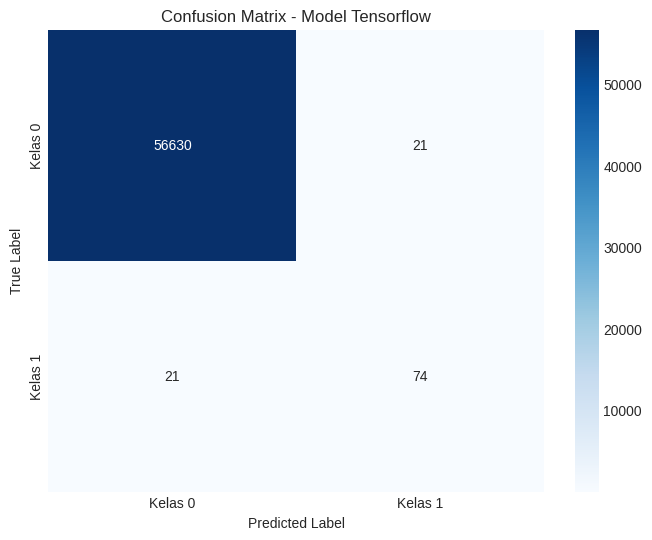

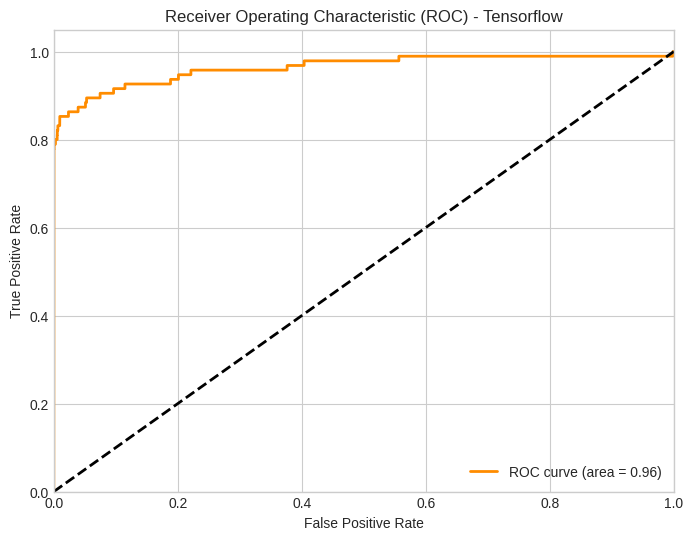


--- Evaluasi Model PyTorch (Multi-Kelas) ---

Laporan Klasifikasi:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56651
           1       0.87      0.58      0.70        95

    accuracy                           1.00     56746
   macro avg       0.94      0.79      0.85     56746
weighted avg       1.00      1.00      1.00     56746



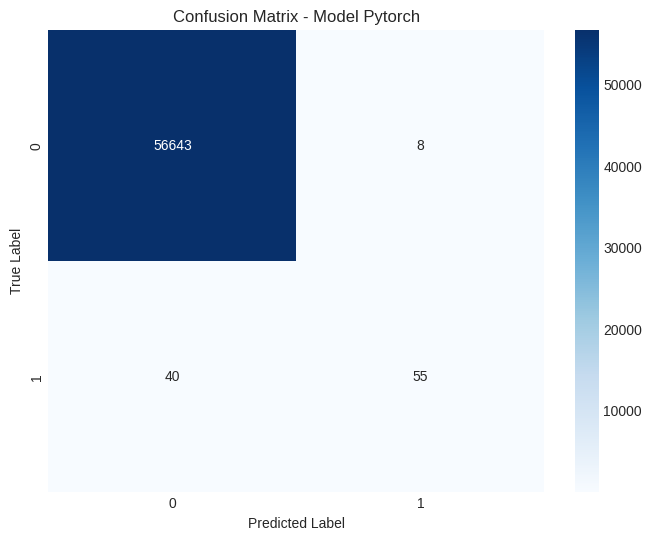

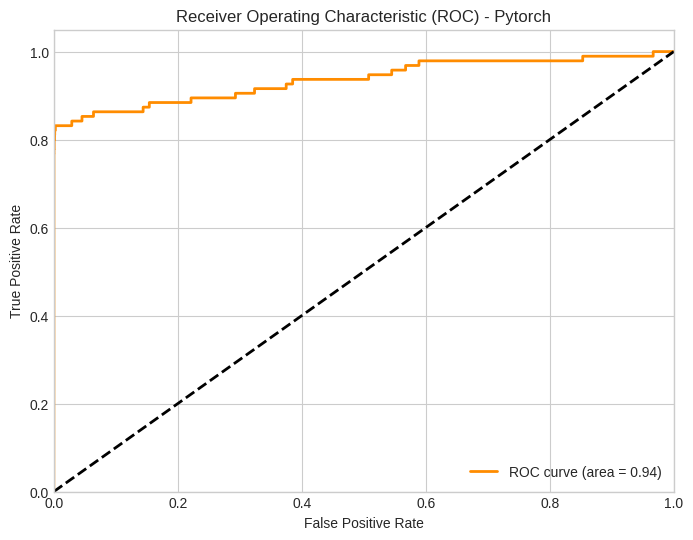

In [16]:
# =============================================================================
# # 5. Matriks Evaluasi & Visualisasi
# =============================================================================
print("\nMemulai Tahap 5: Evaluasi Model...")

def evaluate_model(model, X_test, y_test_true, model_type='tensorflow', main_class_label=None):
    """Fungsi untuk mengevaluasi model dan menampilkan hasilnya."""

    if model_type == 'tensorflow':
        y_pred_prob = model.predict(X_test).flatten()
        y_pred_class = (y_pred_prob > 0.5).astype(int)
        y_true = y_test_true
        if main_class_label is not None:
            target_names = [f'Bukan kelas {main_class_label}', f'Kelas {main_class_label}']
        else:
            # Fallback jika dataset aslinya sudah biner
            target_names = ['Kelas 0', 'Kelas 1']

    elif model_type == 'pytorch':
        model.eval()
        with torch.no_grad():
            outputs = model(torch.tensor(X_test, dtype=torch.float32).to(device))
            y_pred_prob_all = torch.softmax(outputs, dim=1).cpu().numpy()
            if y_pred_prob_all.shape[1] == 2:
                y_pred_prob = y_pred_prob_all[:, 1]
            else:
                y_pred_prob = y_pred_prob_all
            y_pred_class = torch.argmax(outputs, dim=1).cpu().numpy()
        y_true = y_test_true
        target_names = le.classes_.astype(str)

    # Laporan Klasifikasi (Presisi, Recall, F1-score)
    print("\nLaporan Klasifikasi:")
    print(classification_report(y_true, y_pred_class, target_names=target_names, zero_division=0))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred_class)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
    plt.title(f'Confusion Matrix - Model {model_type.capitalize()}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    # Kurva ROC & AUC
    plt.figure(figsize=(8, 6))
    # Biner atau Multi-kelas dengan One-vs-Rest
    if hasattr(y_pred_prob, 'shape') and len(y_pred_prob.shape) > 1 and y_pred_prob.shape[1] > 1: # Multi-kelas
        roc_auc = roc_auc_score(y_true, y_pred_prob, multi_class='ovr', average='macro')
        print(f"Macro-average ROC AUC score (One-vs-Rest): {roc_auc:.4f}")
        # Untuk visualisasi, kita plot kurva untuk setiap kelas
        y_true_bin = label_binarize(y_true, classes=np.arange(num_classes))
        for i in range(num_classes):
            fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_prob[:, i])
            plt.plot(fpr, tpr, label=f'ROC curve of class {le.classes_[i]} (area = {auc(fpr, tpr):.2f})')
    else: # Biner
        fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic (ROC) - {model_type.capitalize()}')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

# --- EVALUASI ---
print("\n--- Evaluasi Model TensorFlow (Biner) ---")
# PERBAIKAN: Gunakan try-except untuk menangani NameError jika sel dijalankan tidak berurutan.
# Ini membuat kode lebih tangguh.
try:
    mc_for_eval = main_class
except NameError:
    mc_for_eval = None
evaluate_model(tf_model, X_test_scaled, y_test_binary, model_type='tensorflow', main_class_label=mc_for_eval)

print("\n--- Evaluasi Model PyTorch (Multi-Kelas) ---")
evaluate_model(pt_model, X_test_scaled, y_test_encoded, model_type='pytorch')


# Penjelasan Matriks Evaluasi KlasifikasiUTS.csv

Pemilihan matriks evaluasi yang tepat dalam konteks dataset **KlasifikasiUTS.csv** sangat bergantung pada tujuan bisnis dan makna dari kolom **Class** dalam dataset. Berikut adalah metrik evaluasi utama yang relevan dan bagaimana mereka dapat digunakan berdasarkan karakteristik dataset ini:

### **1. Recall (Sensitivitas)**
Recall mengukur seberapa baik model dalam menemukan semua sampel positif yang relevan.

#### Kapan Ini Penting?
Jika **Class 1** atau kelas minoritas dalam dataset Anda mewakili kasus yang sangat krusial (misalnya, **penipuan (fraud)**), maka **Recall** sangat penting. Dalam konteks penipuan, kehilangan satu kasus fraud (False Negative) jauh lebih merugikan daripada salah menandai transaksi normal sebagai fraud (False Positive). Oleh karena itu, Anda ingin **memaksimalkan Recall** agar tidak melewatkan kasus-kasus penting.

#### Rumus Recall:
$$
\text{Recall} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Negatives}}
$$



### **2. Presisi (Precision)**
Presisi mengukur keakuratan dari prediksi positif yang dibuat oleh model.

#### Kapan Ini Penting?
Jika setiap kasus yang ditandai sebagai "positif" (misalnya, Class 1) memerlukan penyelidikan manual yang mahal oleh tim analis, maka **Presisi** menjadi sangat penting. Anda tidak ingin membuang waktu atau sumber daya untuk menyelidiki terlalu banyak alarm palsu (False Positives).

#### Rumus Presisi:
$$
\text{Presisi} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Positives}}
$$



### **3. F1-Score**
F1-Score adalah rata-rata harmonik antara **Presisi** dan **Recall**, memberikan skor yang seimbang antara keduanya.

#### Kapan Ini Penting?
Jika Anda tidak ingin kedua kesalahan—**False Positive** dan **False Negative**—terjadi dalam jumlah yang besar, maka **F1-Score** adalah metrik yang sangat baik. F1-Score akan memberikan gambaran yang lebih adil tentang performa model, terutama jika terdapat **ketidakseimbangan kelas** (misalnya, jika kelas fraud jauh lebih sedikit daripada transaksi normal).

#### Rumus F1-Score:
$$
\text{F1-Score} = 2 \times \frac{\text{Presisi} \times \text{Recall}}{\text{Presisi} + \text{Recall}}
$$


### **4. ROC AUC (Area Under the Curve)**
ROC AUC mengukur kemampuan model untuk membedakan antara kelas positif dan negatif, terlepas dari threshold klasifikasi yang dipilih.

#### Kapan Ini Penting?
Metrik ini sangat berguna untuk mendapatkan gambaran umum tentang **seberapa baik model dapat membedakan kelas** tanpa terikat pada threshold klasifikasi tertentu. Nilai AUC yang lebih tinggi (mendekati 1) menunjukkan model yang lebih percaya diri dalam membedakan antara kelas-kelas yang ada. Metrik ini ideal untuk **membandingkan model-model berbeda** atau ketika Anda bekerja dengan data yang tidak seimbang, seperti fraud detection.



## **Metrik Terbaik untuk Proyek Ini?**

Jika kita tidak tahu makna pasti dari setiap **Class** dalam dataset **KlasifikasiUTS.csv**, maka **F1-Score (Macro Average untuk multi-kelas)** dan **ROC AUC** adalah metrik awal yang paling **safely informative**. Keduanya dapat menangani **ketidakseimbangan kelas** dengan baik dan memberikan ukuran performa yang **seimbang dan holistik**.


# Analisis Performa dan Model Mana yang Terbaik?

Dua pendekatan yang berbeda dibandingkan untuk masalah klasifikasi ini:

### **1. Model TensorFlow (Klasifikasi Biner)**
#### Tujuan Spesifik:
Model ini dilatih untuk membedakan antara kelas mayoritas (diasumsikan sebagai "normal") dengan kelas lainnya yang dianggap "anomali". Ini adalah pendekatan klasik yang digunakan untuk **deteksi anomali**, di mana tugas utama model adalah **mengidentifikasi data yang berbeda secara mencolok** dari pola normal.

#### Performa yang Diharapkan:
Model ini diharapkan memiliki skor **Presisi**, **Recall**, **F1-Score**, dan **AUC** yang sangat tinggi. Hal ini disebabkan oleh **kesederhanaan tugasnya**, yaitu hanya membedakan antara data "normal" dan "anomali". Model ini tidak perlu membedakan berbagai jenis anomali, yang membuat tugasnya lebih sederhana dan lebih fokus.

#### Konteks Penggunaan:
Model ini sangat cocok untuk **sistem peringatan dini (early warning system)**, di mana Anda ingin dengan cepat **menyaring transaksi normal** dan hanya menandai sebagian kecil transaksi yang mencurigakan (anomali) untuk dianalisis lebih lanjut. Model biner ini sangat efisien dalam memisahkan data normal dari anomali.


### **2. Model PyTorch (Klasifikasi Multi-Kelas)**
#### Tujuan Spesifik:
Model ini lebih kompleks dan dirancang untuk mengklasifikasikan setiap sampel data ke dalam **beberapa kategori**. Ini berarti model ini dapat mengidentifikasi jenis-jenis **anomali** yang berbeda, misalnya Class 1 adalah penipuan tipe A, Class 2 adalah penipuan tipe B, dan seterusnya.

#### Performa yang Diharapkan:
Skor rata-rata (macro-average) untuk **Presisi**, **Recall**, dan **F1-Score** akan lebih rendah daripada model biner karena **kesulitan** dalam membedakan antara beberapa kelas, terutama jika kelas-kelas tersebut sangat mirip. Meskipun demikian, **model multi-kelas memberikan informasi yang lebih kaya** yang dapat digunakan untuk penanganan anomali yang lebih spesifik.

#### Konteks Penggunaan:
Model ini sangat berguna jika Anda perlu **menangani berbagai jenis anomali secara terpisah**. Sebagai contoh, **penipuan jenis A** bisa ditangani oleh tim A, sedangkan **penipuan jenis B** bisa ditangani oleh tim B. Model multi-kelas memberikan wawasan yang lebih spesifik dan dapat menghasilkan respons yang lebih terarah.



## **Kesimpulan: Model Mana yang Terbaik untuk KlasifikasiUTS.csv?**

Pemilihan model bergantung pada **tujuan bisnis akhir** dan **kebutuhan analisis**.

### Pilih **Model TensorFlow (Biner)** jika...
- Tujuan Anda adalah untuk **deteksi cepat dan efisien**, yaitu menyaring sebagian besar transaksi normal dan hanya menandai sebagian kecil yang berisiko untuk dianalisis lebih lanjut. Model ini sangat efektif dalam membedakan data **normal vs. anomali**.

### Pilih **Model PyTorch (Multi-Kelas)** jika...
- Tujuan Anda adalah untuk **analisis mendalam** dan **respons tersegmentasi**, di mana Anda ingin memahami jenis-jenis anomali yang ada dan menangani masing-masing jenis dengan cara yang berbeda. Model ini memberikan **wawasan granular** dan memungkinkan respons yang lebih **spesifik**.



## **Rekomendasi Akhir:**
Untuk kebanyakan sistem analitik modern, pendekatan **multi-kelas** (PyTorch) menawarkan pemahaman yang lebih mendalam tentang data dan memberikan wawasan lebih banyak, membuatnya menjadi pilihan lebih kuat dalam jangka panjang. Namun, jika prioritas Anda adalah untuk membangun **filter pertama yang sangat akurat** dengan **sumber daya terbatas**, maka **model biner (TensorFlow)** adalah pilihan yang lebih pragmatis dan memberikan performa tinggi untuk tugas spesifiknya.
